# Supplier Performance Analysis: Predicting On-Time Delivery from SAP ERP Data

This project analyzes SAP ERP procurement data to predict whether a supplier delivers purchase orders on time.  
We focus on data cleaning, exploration, and advanced analytics, aiming to build a predictive model for delivery performance.

**Author:** Yury Besiakov
**Dataset:** Kaggle [SAP BigQuery Dataset](https://www.kaggle.com/datasets/mustafakeser4/sap-dataset-bigquery-dataset/data)


In [1]:
# 📦 Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set plotting style for consistency
sns.set(style="whitegrid", palette="Set2")


## Load Data
I’ll start with data cleaning and initial exploration on:
- Purchase order items (`ekpo`)
- Purchase order history (`ekbe`)
- Vendor master data (`lfa1`)
- Purchase order headers (`ekko`)


In [2]:
# Load CSV files
ekpo = pd.read_csv('/kaggle/input/sap-dataset-bigquery-dataset/ekpo.csv')
ekbe = pd.read_csv('/kaggle/input/sap-dataset-bigquery-dataset/ekbe.csv')
lfa1 = pd.read_csv('/kaggle/input/sap-dataset-bigquery-dataset/lfa1.csv')
ekko = pd.read_csv('/kaggle/input/sap-dataset-bigquery-dataset/ekko.csv')


/tmp/ipykernel_36/313143734.py:2: DtypeWarning: Columns (3,4,7,8,50,51,58,85,101,115,163,166) have mixed types. Specify dtype option on import or set low_memory=False.
  ekpo = pd.read_csv('/kaggle/input/sap-dataset-bigquery-dataset/ekpo.csv')
/tmp/ipykernel_36/313143734.py:3: DtypeWarning: Columns (21,22,32,37,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  ekbe = pd.read_csv('/kaggle/input/sap-dataset-bigquery-dataset/ekbe.csv')
/tmp/ipykernel_36/313143734.py:5: DtypeWarning: Columns (5,6,12,38,46,47,53,67,95) have mixed types. Specify dtype option on import or set low_memory=False.
  ekko = pd.read_csv('/kaggle/input/sap-dataset-bigquery-dataset/ekko.csv')


## Quick Data Inspection
Check basic info, missing values, and head of each DataFrame.


In [3]:
import warnings
warnings.filterwarnings('ignore')

# Quick inspection function
def inspect(df, name):
    print(f"--- {name} ---")
    display(df.head())
    print(df.info())
    #print(df.isnull().sum().sort_values(ascending=False)[:10])
    print("\n")

#Take out NuN colums
ekpo=ekpo.dropna(axis=1,how='all')
ekbe=ekbe.dropna(axis=1,how='all')
lfa1=lfa1.dropna(axis=1,how='all')
ekko=ekko.dropna(axis=1,how='all')


inspect(ekpo, "EKPO (PO Items)")
inspect(ekbe, "EKBE (PO History)")
inspect(lfa1, "LFA1 (Vendor Master)")
inspect(ekko, "EKKO (PO Headers)")


--- EKPO (PO Items) ---


,mandt,ebeln,ebelp,loekz,statu,aedat,txz01,matnr,ematn,bukrs,...,retpo,lfret,bonba,tzonrc,ccomp,creationdate,creationtime,operation_flag,is_deleted,recordstamp
0,250,4500000000,10,NaN,NaN,2022-01-17,Test Dry Good,TEST CPG1,TEST CPG1,USA1,...,NaN,NaN,100.0,EST,NaN,2022-01-14,10:41:27,L,False,2022-01-31 20:42:02.329876+00:00
1,250,4500000002,10,NaN,NaN,2022-01-19,Test Dry Good,TEST CPG1,TEST CPG1,USA1,...,NaN,NaN,200.0,EST,NaN,2022-01-19,15:15:51,L,False,2022-01-31 20:42:02.329876+00:00
2,250,4500000000,10,NaN,NaN,2022-02-22,Test Dry Good,TEST CPG1,TEST CPG1,USA1,...,NaN,NaN,100.0,EST,NaN,2022-01-14,10:41:27,U,False,2022-02-22 08:45:41.745178+00:00
3,250,4500000000,10,NaN,NaN,2022-02-25,Test Dry Good,TEST CPG1,TEST CPG1,USA1,...,NaN,NaN,100.0,EST,NaN,2022-01-14,10:41:27,U,False,2022-02-25 11:09:10.788204+00:00
4,250,4500000002,10,NaN,NaN,2022-02-25,Test Dry Good,TEST CPG1,TEST CPG1,USA1,...,NaN,NaN,200.0,EST,NaN,2022-01-19,15:15:51,U,False,2022-02-25 11:09:10.788204+00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125724 entries, 0 to 125723
Data columns (total 70 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   mandt           125724 non-null  int64  
 1   ebeln           125724 non-null  int64  
 2   ebelp           125724 non-null  int64  
 3   loekz           2778 non-null    object 
 4   statu           75 non-null      object 
 5   aedat           125724 non-null  object 
 6   txz01           125724 non-null  object 
 7   matnr           125724 non-null  object 
 8   ematn           125724 non-null  object 
 9   bukrs           125724 non-null  object 
 10  werks           125724 non-null  int64  
 11  lgort           125590 non-null  float64
 12  matkl           125717 non-null  object 
 13  infnr           125702 non-null  float64
 14  menge           125724 non-null  float64
 15  meins           125724 non-null  object 
 16  bprme           125724 non-null  object 
 17  bpumz     

,mandt,ebeln,ebelp,zekkn,vgabe,gjahr,belnr,buzei,bewtp,bwart,...,ernam,arewb,rewrb,saprl,arewr_pop,vbeln_st,vbelp_st,operation_flag,is_deleted,recordstamp
0,250,4500000006,10,NaN,8,NaN,80000014,10,L,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,False,2022-01-31 20:41:57.486125+00:00
1,250,4500000011,10,NaN,8,NaN,80000015,10,L,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,False,2022-01-31 20:41:57.486125+00:00
2,250,4500000012,10,NaN,8,NaN,80000016,10,L,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,False,2022-01-31 20:41:57.486125+00:00
3,250,4500000013,10,NaN,8,NaN,80000017,10,L,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,False,2022-01-31 20:41:57.486125+00:00
4,250,4500000014,10,NaN,8,NaN,80000018,10,L,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,False,2022-01-31 20:41:57.486125+00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123997 entries, 0 to 123996
Data columns (total 49 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   mandt           123997 non-null  int64  
 1   ebeln           123997 non-null  int64  
 2   ebelp           123997 non-null  int64  
 3   zekkn           71 non-null      float64
 4   vgabe           123997 non-null  int64  
 5   gjahr           123980 non-null  float64
 6   belnr           123997 non-null  int64  
 7   buzei           123997 non-null  int64  
 8   bewtp           123997 non-null  object 
 9   bwart           63242 non-null   float64
 10  budat           123997 non-null  object 
 11  menge           123997 non-null  float64
 12  bpmng           123951 non-null  float64
 13  dmbtr           123957 non-null  float64
 14  wrbtr           123957 non-null  float64
 15  waers           123980 non-null  object 
 16  arewr           60667 non-null   float64
 17  shkzg     

,mandt,lifnr,land1,name1,name2,name3,name4,ort01,ort02,pfach,...,qssysdat,podkzb,ric,legalnat,pson1,pson2,psovn,operation_flag,is_deleted,recordstamp
0,800,0000001111,US,Suppliers Inc.,NaN,NaN,NaN,NILES,COOK,NaN,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,I,False,2021-03-31 02:47:30.036270+00:00
1,800,0000003920,US,Pyramid Systems,NaN,NaN,NaN,SANTA CLARA,SANTA CLARA,NaN,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,I,False,2021-03-31 02:47:30.036270+00:00
2,800,0000003411,US,Delta Steel Inc.,NaN,NaN,NaN,HOUSTON,MATANUSKA-SUSITNA BO,NaN,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,I,False,2021-03-31 02:47:30.036270+00:00
3,800,0000003020,US,World Wide Computer Warehouse,NaN,NaN,NaN,SAN JOSE,SANTA CLARA,NaN,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,I,False,2021-03-31 02:47:30.036270+00:00
4,800,AVPL,US,American Vice President Line,Global Shipping,NaN,NaN,Oakland,ALAMEDA,NaN,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,I,False,2021-03-31 02:47:30.036270+00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3035 entries, 0 to 3034
Data columns (total 87 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mandt           3035 non-null   int64  
 1   lifnr           3035 non-null   object 
 2   land1           3032 non-null   object 
 3   name1           3030 non-null   object 
 4   name2           462 non-null    object 
 5   name3           3 non-null      object 
 6   name4           1 non-null      object 
 7   ort01           2785 non-null   object 
 8   ort02           960 non-null    object 
 9   pfach           111 non-null    object 
 10  pstl2           108 non-null    object 
 11  pstlz           2615 non-null   object 
 12  regio           1667 non-null   object 
 13  sortl           3012 non-null   object 
 14  stras           2577 non-null   object 
 15  adrnr           3035 non-null   int64  
 16  mcod1           3029 non-null   object 
 17  mcod2           462 non-null    o

,mandt,ebeln,bukrs,bstyp,bsart,bsakz,loekz,statu,aedat,ernam,...,lifre,exnum,upinc,lands,stceg_l,procstat,inco2_l,operation_flag,is_deleted,recordstamp
0,250,4500001085,EU01,F,UB,T,NaN,9,2022-02-10,MALVIYAH,...,NaN,NaN,1,NL,NL,2.0,NaN,I,False,2022-02-10 07:05:37.818099+00:00
1,250,4500001086,EU01,F,UB,T,NaN,9,2022-02-10,MALVIYAH,...,NaN,NaN,1,NL,NL,2.0,NaN,I,False,2022-02-10 07:17:27.942806+00:00
2,250,4500001192,EU01,F,UB,T,NaN,9,2022-02-24,MALVIYAH,...,NaN,NaN,1,NL,NL,2.0,NaN,I,False,2022-02-24 06:53:25.370603+00:00
3,250,4500000024,USA1,F,UB,T,NaN,9,2022-01-25,MALVIYAH,...,NaN,NaN,1,US,US,2.0,NaN,L,False,2022-01-31 20:42:01.546635+00:00
4,250,4500000030,USA1,F,UB,T,NaN,9,2022-01-28,MALVIYAH,...,NaN,NaN,1,US,US,2.0,NaN,L,False,2022-01-31 20:42:01.546635+00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76362 entries, 0 to 76361
Data columns (total 40 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mandt           76362 non-null  int64  
 1   ebeln           76362 non-null  int64  
 2   bukrs           76362 non-null  object 
 3   bstyp           76362 non-null  object 
 4   bsart           76362 non-null  object 
 5   bsakz           7 non-null      object 
 6   loekz           2771 non-null   object 
 7   statu           76362 non-null  object 
 8   aedat           76362 non-null  object 
 9   ernam           76362 non-null  object 
 10  pincr           76362 non-null  int64  
 11  lponr           76362 non-null  int64  
 12  lifnr           76355 non-null  object 
 13  spras           76362 non-null  object 
 14  zterm           71837 non-null  float64
 15  zbd1t           71834 non-null  float64
 16  zbd2t           71834 non-null  float64
 17  zbd1p           71834 non-null 

## Data Cleaning Steps

- Remove duplicates  
- Handle missing values (focus on critical columns)
- Ensure consistent datatypes (e.g., date columns as datetime)
- Basic filtering for realistic entries (e.g., positive quantities, valid vendor numbers)


In [4]:
ekpo.columns

Index(['mandt', 'ebeln', 'ebelp', 'loekz', 'statu', 'aedat', 'txz01', 'matnr',
       'ematn', 'bukrs', 'werks', 'lgort', 'matkl', 'infnr', 'menge', 'meins',
       'bprme', 'bpumz', 'bpumn', 'umrez', 'umren', 'netpr', 'peinh', 'netwr',
       'brtwr', 'webaz', 'mwskz', 'spinf', 'prsdr', 'mahn1', 'elikz', 'pstyp',
       'knttp', 'kzvbr', 'wepos', 'repos', 'webre', 'kzabs', 'lmein', 'evers',
       'prdat', 'bstyp', 'effwr', 'kunnr', 'adrnr', 'stafo', 'plifz', 'ntgew',
       'gewei', 'txjcd', 'bstae', 'ko_prctr', 'brgew', 'inco1', 'inco2',
       'stapo', 'drunr', 'banfn', 'bnfpo', 'mtart', 'retpo', 'lfret', 'bonba',
       'tzonrc', 'ccomp', 'creationdate', 'creationtime', 'operation_flag',
       'is_deleted', 'recordstamp'],
      dtype='object')

In [5]:
# Remove Duplicates
ekpo.drop_duplicates(inplace=True)
ekbe.drop_duplicates(inplace=True)
lfa1.drop_duplicates(inplace=True)
ekko.drop_duplicates(inplace=True)

# Handle Missing Values (report and clean critical ones)
critical_ekpo = ['ebeln', 'ebelp', 'matnr', 'menge']
critical_ekbe = ['ebeln', 'ebelp', 'budat', 'menge']
critical_lfa1 = ['lifnr']
critical_ekko = ['ebeln', 'lifnr', 'bedat']

for col in critical_ekpo:
    ekpo = ekpo[ekpo[col].notnull()]

for col in critical_ekbe:
    ekbe = ekbe[ekbe[col].notnull()]

for col in critical_lfa1:
    lfa1 = lfa1[lfa1[col].notnull()]

for col in critical_ekko:
    ekko = ekko[ekko[col].notnull()]

# Datatype Conversions
date_columns_ekbe = ['budat', 'cpudt']
for col in date_columns_ekbe:
    if col in ekbe.columns:
        ekbe[col] = pd.to_datetime(ekbe[col], errors='coerce')

if 'bedat' in ekko.columns:
    ekko['bedat'] = pd.to_datetime(ekko['bedat'], errors='coerce')

# 3.4 Filter for realistic entries (example: positive quantities)
ekpo = ekpo[ekpo['menge'] > 0]
ekbe = ekbe[ekbe['menge'] > 0]


## Consistency Checks & Merging Keys

check key relationships:
- `ebeln` (PO Number): exists in `ekpo`, `ekbe`, `ekko`
- `ebelp` (Item Number): `ekpo` & `ekbe`
- `lifnr` (Vendor): `ekpo`, `ekko`, `lfa1`


In [6]:
# How many unique POs and Vendors?
print(f"POs in EKPO: {ekpo['ebeln'].nunique()}, in EKBE: {ekbe['ebeln'].nunique()}, in EKKO: {ekko['ebeln'].nunique()}")

# Vendors: Only in LFA1 and EKKO, NOT in EKPO!
print(f"Vendors in LFA1: {lfa1['lifnr'].nunique()}, in EKKO: {ekko['lifnr'].nunique()}")

# Do all PO numbers in EKPO exist in EKKO?
missing_ekko = set(ekpo['ebeln']) - set(ekko['ebeln'])
print(f"POs in EKPO not in EKKO: {len(missing_ekko)}")


POs in EKPO: 69428, in EKBE: 63222, in EKKO: 69424
Vendors in LFA1: 2590, in EKKO: 44
POs in EKPO not in EKKO: 4


In [7]:
# remove POs in EKPO that are not in EKKO
ekpo = ekpo[ekpo['ebeln'].isin(ekko['ebeln'])]

In [8]:
for df in [ekpo,ekbe,ekko]:
    print(df.columns)

Index(['mandt', 'ebeln', 'ebelp', 'loekz', 'statu', 'aedat', 'txz01', 'matnr',
       'ematn', 'bukrs', 'werks', 'lgort', 'matkl', 'infnr', 'menge', 'meins',
       'bprme', 'bpumz', 'bpumn', 'umrez', 'umren', 'netpr', 'peinh', 'netwr',
       'brtwr', 'webaz', 'mwskz', 'spinf', 'prsdr', 'mahn1', 'elikz', 'pstyp',
       'knttp', 'kzvbr', 'wepos', 'repos', 'webre', 'kzabs', 'lmein', 'evers',
       'prdat', 'bstyp', 'effwr', 'kunnr', 'adrnr', 'stafo', 'plifz', 'ntgew',
       'gewei', 'txjcd', 'bstae', 'ko_prctr', 'brgew', 'inco1', 'inco2',
       'stapo', 'drunr', 'banfn', 'bnfpo', 'mtart', 'retpo', 'lfret', 'bonba',
       'tzonrc', 'ccomp', 'creationdate', 'creationtime', 'operation_flag',
       'is_deleted', 'recordstamp'],
      dtype='object')
Index(['mandt', 'ebeln', 'ebelp', 'zekkn', 'vgabe', 'gjahr', 'belnr', 'buzei',
       'bewtp', 'bwart', 'budat', 'menge', 'bpmng', 'dmbtr', 'wrbtr', 'waers',
       'arewr', 'shkzg', 'elikz', 'xblnr', 'lfgja', 'lfbnr', 'lfpos', 'cpudt',
  

In [9]:
# List key columns by df
ekpo_key_cols = ['menge', 'netpr', 'netwr', 'brtwr', 'effwr', 'aedat', 'prdat', 'creationdate']
ekbe_key_cols = ['menge', 'bpmng', 'lsmng', 'bamng', 'dmbtr', 'wrbtr', 'reewr', 'refwr', 'arewr', 'budat', 'cpudt', 'bldat']
ekko_key_cols = ['aedat', 'bedat']

# Function to report NA counts
def report_na(df, cols, dfname):
    print(f"\nMissing values in {dfname}:")
    print(df[cols].isnull().sum().sort_values(ascending=False))
    
report_na(ekpo, [col for col in ekpo_key_cols if col in ekpo.columns], 'EKPO')
report_na(ekbe, [col for col in ekbe_key_cols if col in ekbe.columns], 'EKBE')
report_na(ekko, [col for col in ekko_key_cols if col in ekko.columns], 'EKKO')



Missing values in EKPO:
netpr           15
netwr           15
brtwr           15
effwr           15
prdat            8
menge            0
aedat            0
creationdate     0
dtype: int64

Missing values in EKBE:
lsmng    123966
arewr     63330
reewr     63259
refwr     63259
bamng     60755
bpmng        46
dmbtr        40
wrbtr        40
bldat        17
menge         0
budat         0
cpudt         0
dtype: int64

Missing values in EKKO:
aedat    0
bedat    0
dtype: int64


## 🧹 Data Cleaning: Handling Missing Values

### Overview

Before proceeding with analysis, it's crucial to address missing values in key columns related to quantities, amounts, and dates. These fields are central to understanding supplier performance and are often required for any kind of modeling or visualization.

### Key Columns and Their Meanings

- **menge**: Quantity ordered (EKPO) or movement quantity (EKBE)
- **netpr**: Net price per unit (EKPO)
- **netwr**: Net value of the purchase order item (EKPO)
- **brtwr**: Gross value of the PO item (EKPO)
- **effwr**: Effective order value (EKPO)
- **prdat**: Requested delivery date (EKPO)
- **aedat**: Document (change/creation) date (EKPO/EKKO)
- **creationdate**: Date this data row was created in the system (EKPO)
- **bpmng, lsmng, bamng**: Various quantity fields in different units (EKBE)
- **dmbtr, wrbtr, arewr, refwr, reewr**: Various amount fields in different currencies and contexts (EKBE)
- **budat, bldat, cpudt**: Posting/document/entry dates (EKBE)

### Missing Value Handling Strategy

- **Drop rows** with missing values in critical columns that are needed for performance and financial analysis (such as quantities, prices, values, and dates).
    - In the data, only a small number of rows are missing values in these fields, so dropping them will not impact the overall analysis.
- **Retain NAs** in columns with a large number of missing values, especially when these fields are only relevant for specific document types or scenarios (e.g., certain quantities or amounts in EKBE). These will be left as NA for now, but may be filled with zero or further analyzed in advanced modeling if needed.

### Rationale

This approach ensures:
- High data quality for analysis and modeling
- Maximum use of available data, while ensuring that key metrics are never calculated with missing or unreliable values
- Transparency in the data cleaning process for any future reviewer or stakeholder

In [10]:
# EKPO: Drop rows missing critical values or delivery date
ekpo_clean = ekpo.dropna(subset=['netpr', 'netwr', 'brtwr', 'effwr', 'prdat'])

# EKBE: Drop rows missing small number of criticals (bpmng, dmbtr, wrbtr, bldat)
ekbe_clean = ekbe.dropna(subset=['bpmng', 'dmbtr', 'wrbtr', 'bldat'])


### Date Conversion and Logical Consistency Checks

I converted all relevant columns to datetime.  
Next, we ensured that planned or actual delivery/receipt dates never precede order dates.  
Records violating this business logic were removed for robust analysis.


In [11]:
# Helper function to safely convert to datetime
def to_datetime_safe(df, col):
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(f"Converted {col} to datetime.")

# List of date columns per DataFrame
ekpo_dates = ['aedat', 'prdat', 'creationdate']
ekko_dates = ['aedat', 'bedat']
ekbe_dates = ['budat', 'cpudt', 'bldat']

for col in ekpo_dates:
    to_datetime_safe(ekpo, col)
for col in ekko_dates:
    to_datetime_safe(ekko, col)
for col in ekbe_dates:
    to_datetime_safe(ekbe, col)


Converted aedat to datetime.
Converted prdat to datetime.
Converted creationdate to datetime.
Converted aedat to datetime.
Converted bedat to datetime.
Converted budat to datetime.
Converted cpudt to datetime.
Converted bldat to datetime.


In [12]:
# Merge EKPO (delivery date) with EKKO (order date) using PO number (ebeln)
if 'prdat' in ekpo.columns and 'bedat' in ekko.columns:
    ekpo_ekko_dates = ekpo_ekko_dates = ekpo.merge(ekko, on='ebeln', how='inner')
    # Logical test
    inconsistent = ekpo_ekko_dates[ekpo_ekko_dates['prdat'] < ekpo_ekko_dates['bedat']]
    print(f"Found {len(inconsistent)} records where delivery date < order date.")
    # Optionally, filter them out
    ekpo_ekko_dates = ekpo_ekko_dates[ekpo_ekko_dates['prdat'] >= ekpo_ekko_dates['bedat']]


Found 194 records where delivery date < order date.


In [13]:
# Merge actual receipt date (budat, EKBE) with order date (bedat, EKKO)
if 'budat' in ekbe.columns and 'bedat' in ekko.columns:
    ekbe_ekko_dates = ekbe_ekko_dates = ekbe.merge(ekko, on='ebeln', how='inner')
    inconsistent2 = ekbe_ekko_dates[ekbe_ekko_dates['budat'] < ekbe_ekko_dates['bedat']]
    print(f"Found {len(inconsistent2)} records where actual receipt < order date.")
    # Optionally filter:
    ekbe_ekko_dates = ekbe_ekko_dates[ekbe_ekko_dates['budat'] >= ekbe_ekko_dates['bedat']]


Found 122 records where actual receipt < order date.


In [14]:
# After merging, drop duplicate columns
def deduplicate_cols(df):
    # Find all .x/.y duplicates
    dup_cols = set([col[:-2] for col in df.columns if col.endswith('_x')]) & \
               set([col[:-2] for col in df.columns if col.endswith('_y')])
    for base_col in dup_cols:
        # Keep .x by default, or .y if .x is all null
        if df[base_col + '_x'].notnull().sum() >= df[base_col + '_y'].notnull().sum():
            df[base_col] = df[base_col + '_x']
        else:
            df[base_col] = df[base_col + '_y']
        df.drop([base_col + '_x', base_col + '_y'], axis=1, inplace=True)
    return df

ekpo_ekko_dates = deduplicate_cols(ekpo_ekko_dates)
ekbe_ekko_dates = deduplicate_cols(ekbe_ekko_dates)

### Outlier Assessment

Although several business-critical columns show extreme outliers in their distributions, a review of these records suggests they are plausible (e.g., unusually large but realistic orders or deliveries). For this reason, I chose to retain these values in the dataset to preserve the integrity of real business events.

If business logic or domain knowledge indicates that these outliers are erroneous, the the data should be updated accordingly.


# 📊 Supplier Performance: Exploratory Data Analysis

In this section, I explore key insights about suppliers and purchasing activities using SAP procurement data. We'll analyze purchase order quantities, amounts, delivery trends, and vendor performance with rich visualizations.


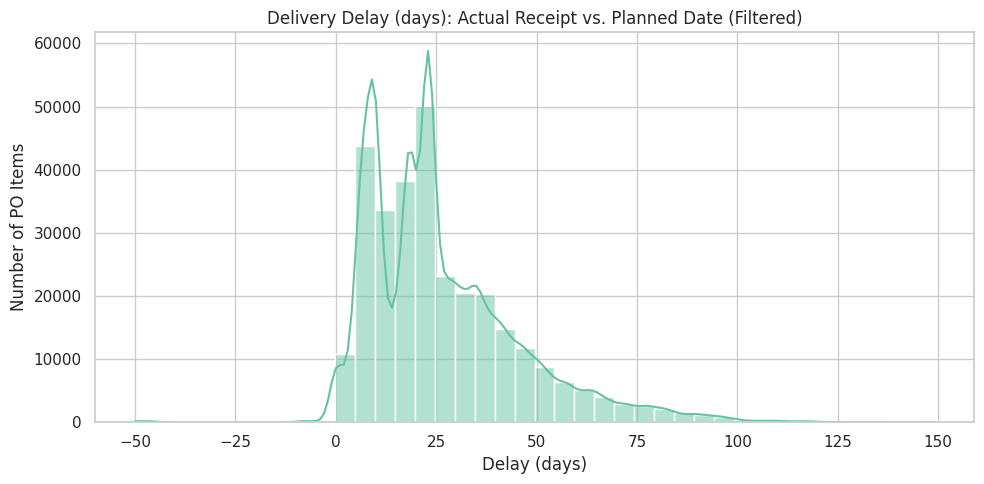

Filtered Delivery Delay Statistics:
count    303529.000000
mean         26.640232
std          19.273039
min         -50.000000
25%          10.000000
50%          23.000000
75%          36.000000
max         149.000000
Name: delivery_delay, dtype: float64


In [15]:
# Merge prdat (planned delivery) from ekpo/ekpo_ekko_dates with budat (actual) from ekbe/ekbe_ekko_dates
# Merge ALL columns from both DataFrames on ['ebeln', 'ebelp']
merged = ekpo_ekko_dates.merge(
    ekbe_ekko_dates, on=['ebeln', 'ebelp'], how='inner'
)
merged = deduplicate_cols(merged)

merged['prdat'] = pd.to_datetime(merged['prdat'], errors='coerce')
merged['budat'] = pd.to_datetime(merged['budat'], errors='coerce')
merged['delivery_delay'] = (merged['budat'] - merged['prdat']).dt.days

# Clean up unrealistic delays
# Delivery Delay Outlier Removal
#To ensure meaningful analysis of delivery performance, we filter out records where the delivery delay is less than -60 days 
# (i.e., delivered extremely early) or more than 180 days late, as these are likely to be data entry errors or highly unusual cases.

filtered = merged[(merged['delivery_delay'] >= -60) & (merged['delivery_delay'] <= 180)]
filtered = deduplicate_cols(filtered)


plt.figure(figsize=(10, 5))
sns.histplot(filtered['delivery_delay'], bins=40, kde=True)
plt.title("Delivery Delay (days): Actual Receipt vs. Planned Date (Filtered)")
plt.xlabel("Delay (days)")
plt.ylabel("Number of PO Items")
plt.tight_layout()
plt.show()

print("Filtered Delivery Delay Statistics:")
print(filtered['delivery_delay'].describe())


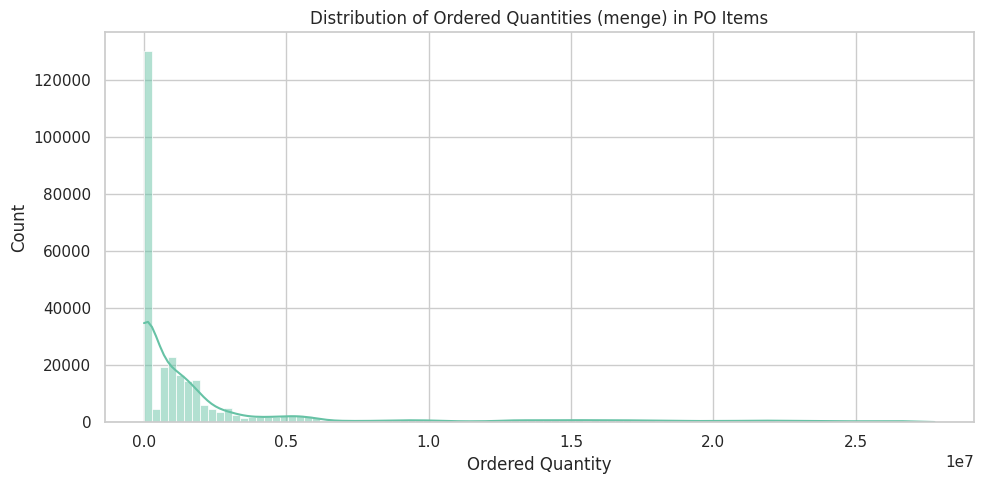

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(filtered['menge'], bins=99, kde=True)
plt.title("Distribution of Ordered Quantities (menge) in PO Items")
plt.xlabel("Ordered Quantity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


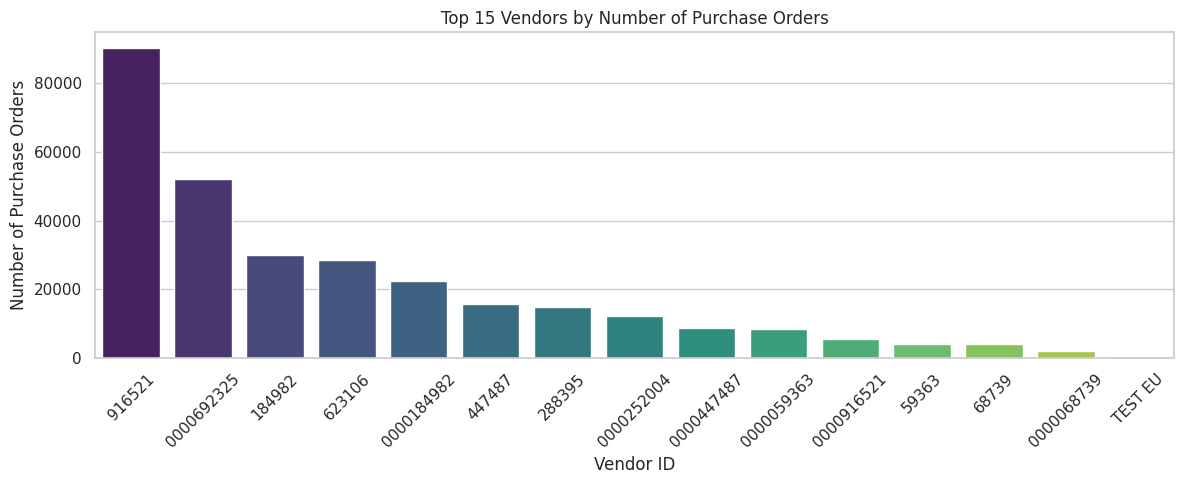

In [17]:
top_vendors = filtered['lifnr'].value_counts().head(15)


plt.figure(figsize=(12, 5))
sns.barplot(x=top_vendors.index, y=top_vendors.values, palette='viridis')
plt.title("Top 15 Vendors by Number of Purchase Orders")
plt.xlabel("Vendor ID")
plt.ylabel("Number of Purchase Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


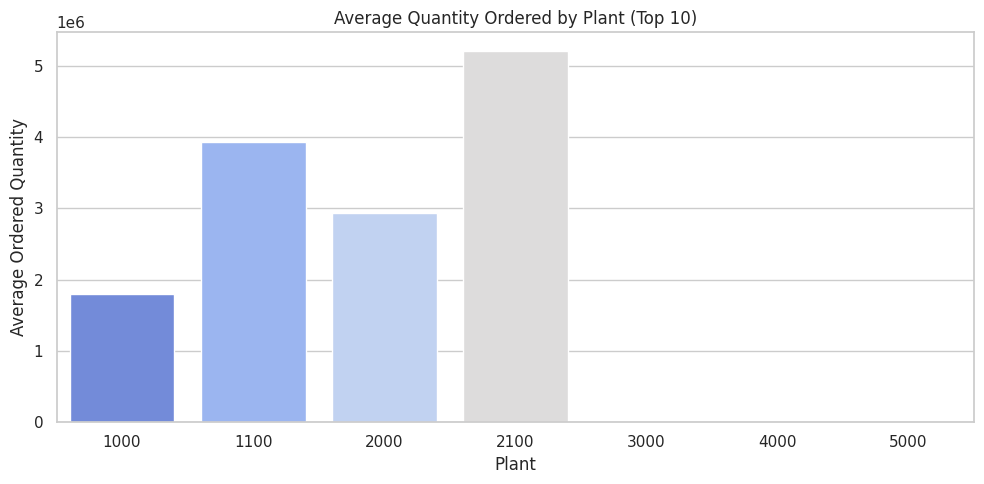

In [18]:
avg_qty_plant = filtered.groupby('werks')['menge'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=avg_qty_plant.index, y=avg_qty_plant.values, palette='coolwarm')
plt.title("Average Quantity Ordered by Plant (Top 10)")
plt.xlabel("Plant")
plt.ylabel("Average Ordered Quantity")
plt.tight_layout()
plt.show()


In [19]:
revenue_by_plant = filtered.groupby('werks')['netwr'].sum().reset_index()


In [20]:
t001w = pd.read_csv("/kaggle/input/sap-dataset-bigquery-dataset/t001w.csv")
adrc = pd.read_csv("/kaggle/input/sap-dataset-bigquery-dataset/adrc.csv")

# Merge t001w and adrc on 'adrnr'
plant_geo = t001w.merge(adrc, left_on='adrnr', right_on='addrnumber', how='left')


In [21]:
# Convert key columns to string
t001w['adrnr'] = t001w['adrnr'].astype(str)
adrc['addrnumber'] = adrc['addrnumber'].astype(str)
t001w['werks'] = t001w['werks'].astype(str)
revenue_by_plant['werks'] = revenue_by_plant['werks'].astype(str)

# Merge plant master data with address data
plant_geo = t001w.merge(adrc, left_on='adrnr', right_on='addrnumber', how='left')

# Merge plant revenue with plant geo info
plant_info = revenue_by_plant.merge(plant_geo, on='werks', how='left')


In [22]:
plant_info=plant_info.dropna(axis=1,how='all')
plant_info.columns

Index(['werks', 'netwr', 'mandt', 'name1_x', 'bwkey', 'kunnr', 'lifnr',
       'fabkl', 'name2_x', 'stras', 'pstlz', 'ort01', 'vkorg', 'land1',
       'regio', 'adrnr', 'txjcd', 'vtweg', 'spart', 'spras',
       'operation_flag_x', 'is_deleted_x', 'recordstamp_x'],
      dtype='object')

In [23]:
country_rev = plant_info.groupby('land1', as_index=False)['netwr'].sum()

iso2_to_iso3 = {
    'US': 'USA',
    'NL': 'NLD',
    'DE': 'DEU',
    'CA': 'CAN',
    'JP': 'JPN',
    # Add more as needed
}

country_rev['iso3'] = country_rev['land1'].map(iso2_to_iso3)

fig = px.choropleth(
    country_rev,
    locations='iso3',
    locationmode='ISO-3',
    color='netwr',
    color_continuous_scale='Plasma',
    title="Plant Revenue by Country"
)
fig.show()


## Dimensionality Reduction and Machine Learning Results


### Feature Selection & Preprocessing

First, I selected all numerical columns relevant for modeling, excluding identifiers and dates.  
Missing values were imputed using column means, and features were standardized to zero mean and unit variance for optimal PCA and ML model performance.


In [25]:
# Select numeric columns for PCA
numeric_cols = merged.select_dtypes(include=[np.number]).columns.tolist()
# Remove identifiers and date columns
drop_cols = ['ebeln', 'ebelp', 'delivery_delay', 'recordstamp']  
pca_cols = [col for col in numeric_cols if col not in drop_cols]

# Fill missing values (mean imputation for demonstration)
pca_data = merged[pca_cols].fillna(merged[pca_cols].mean())

# Standardize features
scaler = StandardScaler()
pca_data_scaled = scaler.fit_transform(pca_data)


### Cumulative Explained Variance by PCA

I applied PCA to the scaled features and plotted the cumulative explained variance.  
This plot helps determine how many principal components are needed to capture most of the information in the dataset.


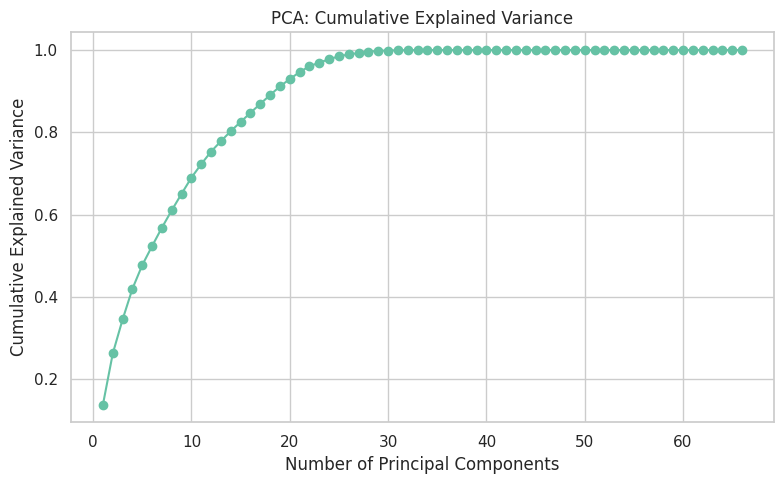

In [26]:
# Fit PCA with all possible components
pca_full = PCA().fit(pca_data_scaled)
explained_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Cumulative Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()


### Optimal Number of Principal Components

Based on the explained variance plot, I selected the minimum number of components needed to reach at least 80% explained variance.  
This balances dimensionality reduction with information retention.


In [27]:
# Choose number of components (e.g., first number reaching >= 80% explained variance)
n_components = np.argmax(explained_var >= 0.80) + 1
print(f"Number of components for >=80% variance: {n_components}")

pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(pca_data_scaled)

print(f"Explained variance by first {n_components} PCs: {explained_var[n_components-1]:.2%}")


Number of components for >=80% variance: 14
Explained variance by first 14 PCs: 80.29%


### Target Variable Construction

To frame a business-relevant prediction problem, I defined a binary target variable:  
**Late delivery** (1 = delivery delay > 0 days, 0 = on-time or early).  
This allows classification of orders as late or not late.


In [28]:
merged['late_delivery'] = (merged['delivery_delay'] > 0).astype(int)
features = pca_cols  
X = merged[features].fillna(merged[features].mean())
y = merged['late_delivery']


In [29]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


### Classification Models: KNN, Random Forest, and Logistic Regression

To predict the likelihood of late deliveries, I trained and evaluated three different classification models:

- **K-Nearest Neighbors (KNN):**  
  A simple, instance-based algorithm that classifies samples based on the majority class of their nearest neighbors.

- **Random Forest:**  
  An ensemble tree-based method that provides strong performance on tabular data and allows for interpretation of feature importances.

- **Logistic Regression:**  
  A linear baseline model useful for assessing how much of the signal can be captured with a simple approach.

Each model was trained on the same features and evaluated on a held-out test set.  
Results are compared using accuracy, precision, recall, and F1-score to assess their effectiveness in predicting late deliveries.


In [30]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


KNN Accuracy: 0.9943363671087813
              precision    recall  f1-score   support

           0       0.96      0.74      0.84      1495
           1       0.99      1.00      1.00     74428

    accuracy                           0.99     75923
   macro avg       0.98      0.87      0.92     75923
weighted avg       0.99      0.99      0.99     75923



In [31]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.9984457937647353
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1495
           1       1.00      1.00      1.00     74428

    accuracy                           1.00     75923
   macro avg       0.99      0.97      0.98     75923
weighted avg       1.00      1.00      1.00     75923



In [32]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.9843393964938161
              precision    recall  f1-score   support

           0       0.68      0.38      0.49      1495
           1       0.99      1.00      0.99     74428

    accuracy                           0.98     75923
   macro avg       0.83      0.69      0.74     75923
weighted avg       0.98      0.98      0.98     75923



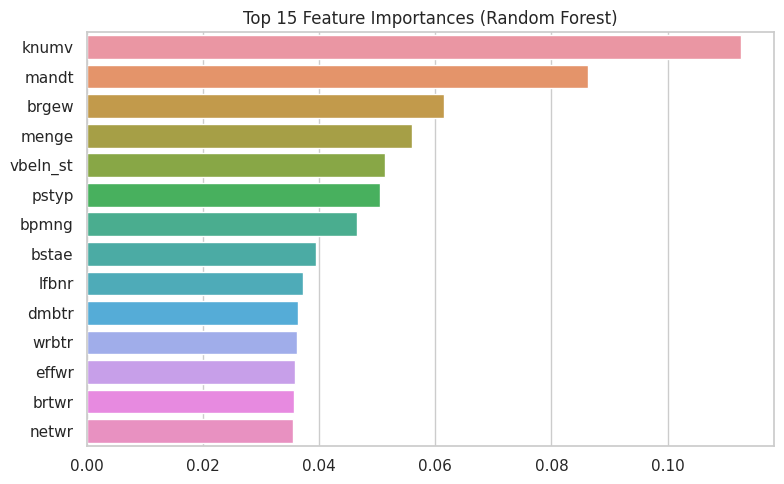

In [33]:
feat_imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False).head(14)
plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top 14 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()
